# One Piece Image Classifier by Ibrahim SEROUIS  👨🏾‍💻

## What is image classification ? 🔍

"Image classification is the process of categorizing and labeling groups of pixels or vectors within an image based on specific rules."

In other words, with Artificial Intelligence and Computer Vision, you can "train" a machine to recognize various objects.

## What to expect 🤔

In this Notebook, we will train a machine learning model to recognize various One Piece characters. 



# Libraries

In [1]:
import os
from pathlib import PosixPath
import random
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
from PIL import Image

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import preprocessing
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

2022-04-27 13:40:01.255075: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# Exploring the dataset 📊

In [2]:
data_path = "/kaggle/input/one-piece-image-classifier/Data/Data/"
data_dir = PosixPath(data_path)

## Image count

In [3]:
image_count = len(list(data_dir.glob("*/*")))
print(f"Image count: {image_count}")

Image count: 11086


##  Display some images

### Get a sample of each class

In [4]:
Luffy = list(data_dir.glob('Luffy/*'))[0]
Nami = list(data_dir.glob('Nami/*'))[0]
Zoro = list(data_dir.glob('Zoro/*'))[0]
Sanji = list(data_dir.glob('Sanji/*'))[0]
Franky = list(data_dir.glob('Franky/*'))[0]
Brook = list(data_dir.glob('Brook/*'))[0]
Chopper = list(data_dir.glob('Chopper/*'))[0]
Usopp = list(data_dir.glob('Usopp/*'))[0]
Robin = list(data_dir.glob('Robin/*'))[0]
Jinbei = list(data_dir.glob('Jinbei/*'))[0]
Ace = list(data_dir.glob('Ace/*'))[0]
Akainu = list(data_dir.glob('Akainu/*'))[0]
Shanks = list(data_dir.glob("Shanks/*"))[0]
Law = list(data_dir.glob("Law/*"))[0]
Crocodile = list(data_dir.glob("Crocodile/*"))[0]
Kurohige = list(data_dir.glob("Kurohige/*"))[0]
Mihawk = list(data_dir.glob("Mihawk/*"))[0]


samples = [Luffy, Nami, Zoro, Sanji, Franky, Brook, Chopper, Crocodile, 
           Usopp, Robin, Jinbei, Ace, Akainu, Shanks, Law, Kurohige, Mihawk]

### Plot the samples

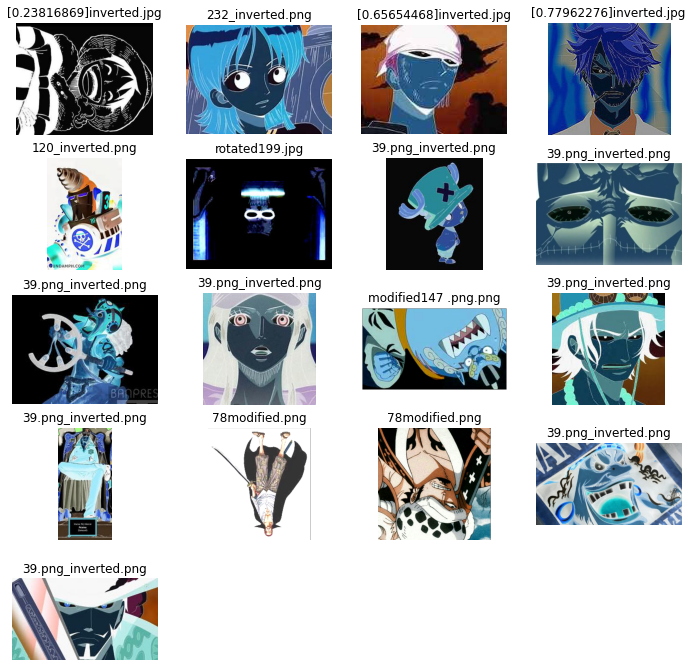

In [5]:
# Create the figure
figure = plt.figure(figsize=(12,12))

# Setup the parameters 
columns = 4 
rows = int(len(samples)/columns +1)
count = 0 

# Loop through the samples
for sample in samples: 
    # Open and plot the sample
    with Image.open(sample) as image:
        # Plot to the count+1 column
        plt.subplot(rows, columns, count+1)
        plt.title(os.path.basename(sample))
        plt.axis("off")
        plt.imshow(image)
        
        count+=1

# Create the model 👨🏾‍🔬

## Setup the seed  

Fixing the seed (random state) parameter makes our splitting operation reproductible by initializing the internal random number generator which will decide the splitting of data into train and test indices in our case.

In [6]:
random.seed(123)
seed = random.randint(0,100)
print(f"Current seed : {seed}")

Current seed : 6


### Batch size, width and height of the input images
- The width and height are tailored to the imagenet classification task 
- The batch size can be adjusted according to our memory

In [7]:
batch_size = 32
width = 224
height = 224

## Training dataset definition
Important parameters : 
- **Directory :** the path to the directory which contains *all* the images. The method will make sure to split the data according to the next parameter
- **Validation split :** the % of the dataset that will be used for validation 

In [8]:
train_dataset = preprocessing.image_dataset_from_directory(
    directory=data_path,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(height,width),
    batch_size=batch_size
)

Found 11086 files belonging to 17 classes.
Using 8869 files for training.


2022-04-27 13:40:09.678374: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-27 13:40:09.681635: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-27 13:40:09.733004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 13:40:09.733732: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-04-27 13:40:09.733804: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-04-27 13:40:09.760374: I tensorflow/stream_executor/platform/def

In [9]:
classes_count = len(train_dataset.class_names)
class_names = train_dataset.class_names
print(f"Class names: {class_names}")

Class names: ['Ace', 'Akainu', 'Brook', 'Chopper', 'Crocodile', 'Franky', 'Jinbei', 'Kurohige', 'Law', 'Luffy', 'Mihawk', 'Nami', 'Robin', 'Sanji', 'Shanks', 'Usopp', 'Zoro']


## Validation dataset definition

Note : Since we're using the same seed than the one in the training subset, there's no need to worry about overlaps in the splitting process. 

> For it to be possible, we need to set the ***subset*** parameter to "validation" instead of "training"

In [10]:
val_dataset = preprocessing.image_dataset_from_directory(
    directory=data_path,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(height, width),
    batch_size=batch_size
)

Found 11086 files belonging to 17 classes.
Using 2217 files for validation.


## Data augmentation

This operation will help us increase the amount of data during training, and potentially reduce overfitting. We'll use 3 data augmentation techniques : 
- **Randomly flipping** the image horizontally and vertically
- **Randomly rotating** the image 
- **Randomly zooming** into the image

In [11]:
data_augmentation = Sequential(
    layers=[
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(height,width,3)),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.1), 
        ], 
    name="data_augmentation"
    )

## Model builder 🧑🏾‍🔧

### Description

* A **data augmentation** layer which creates "modified" images of the training set
* A **MobileNet layer** which detects the features
* A **Global average pooling layer** which converts the feature vector into a 1280 element vector
* 1*3 **Fully connected layers** , each followed by a **dropout layer** to prevent overfitting
* **An activation layer** (sigmoid) which represents the final output: Probability of input(X) belonging to each class

> Note : Output classes (probabilities) : ['Ace', 'Akainu', 'Brook', 'Chopper', 'Crocodile', 'Franky', 'Jinbei', 'Law', 'Luffy', 'Nami', 'Robin', 'Sanji', 'Shanks', 'Usopp', 'Zoro']


In [12]:
def model_builder():
    """
    Generates and compiles the training model
    Returns
    -------
    model : tensorflow.keras.models.Sequential
        The training model
    """

    # Create the model
    model = Sequential()
    
    # Load the pretrained model with its weights
    base_model = tf.keras.applications.MobileNet(input_shape=(width,height,3), weights="imagenet",include_top=False)
    
    # Setup the model : add the data augmentation layer defined above
    model.add(data_augmentation)
    
    # Add the pretrained MobileNet 
    model.add(base_model)
    # Features detector
    model.add(layers.GlobalAveragePooling2D())  
    model.add(layers.BatchNormalization())
    # Fully connected layers 
    model.add(layers.Dense(units=1024, activation="relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(units=1024, activation="relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(units=512, activation="relu"))
    model.add(layers.Dropout(0.2))
    # Final output : probabilities 
    model.add(layers.Dense(classes_count, activation="sigmoid",name="final_output"))
    
    # Compile the model
    model.compile(
        optimizer= optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"])

    return model

# Training ⚗️

## Instantiate the model

In [13]:
model = model_builder()
print(f"Model : {model}")

17227776/17225924 [==============================] - 0s 0us/step
Model : <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fae8887e890>


### Setup early stopping
We setup the Early Stopping callback to stop the training process if the **validation accuracy** stops increasing after 15 epochs, and restore the weights which minimize the **validation accuracy**. 
Important parameters : 
- **Monitor :** keras will stop training when the monitored metric has stopped improving. The direction (minimze or maximize) is automatically infered from the monitored quantity name, although it remains adjustable with the "mode" parameter
- **Patience :** the number of epochs without improvement after which the callback will be triggered (i.e, the model will stop training)
- **Restore best weights :** tells the model to restore the weights from the "best" epoch according to the monitored value

In [14]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", 
    patience=15, 
    mode ="max", 
    verbose=2, 
    restore_best_weights=True
)

## Start the training process

In [15]:
history = model.fit (
    train_dataset,
    validation_data=val_dataset,
    epochs=150,
    verbose=1, 
    callbacks=[stop_early]
)

Epoch 1/150


2022-04-27 13:40:17.022292: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-27 13:40:17.044976: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000189999 Hz
2022-04-27 13:40:17.611428: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-04-27 13:40:18.456926: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-04-27 13:40:21.494782: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


278/278 [==============================] - 170s 569ms/step - loss: 2.2020 - accuracy: 0.3355 - val_loss: 2.3055 - val_accuracy: 0.3194
Epoch 2/150
278/278 [==============================] - 113s 400ms/step - loss: 1.3432 - accuracy: 0.6159 - val_loss: 2.7594 - val_accuracy: 0.4348
Epoch 3/150
278/278 [==============================] - 113s 399ms/step - loss: 1.0726 - accuracy: 0.7004 - val_loss: 2.4122 - val_accuracy: 0.4438
Epoch 4/150
278/278 [==============================] - 113s 400ms/step - loss: 0.9325 - accuracy: 0.7393 - val_loss: 1.5011 - val_accuracy: 0.6166
Epoch 5/150
278/278 [==============================] - 113s 399ms/step - loss: 0.7788 - accuracy: 0.7886 - val_loss: 1.6073 - val_accuracy: 0.6184
Epoch 6/150
278/278 [==============================] - 113s 400ms/step - loss: 0.6628 - accuracy: 0.8162 - val_loss: 1.1731 - val_accuracy: 0.6770
Epoch 7/150
278/278 [==============================] - 113s 401ms/step - loss: 0.6138 - accuracy: 0.8351 - val_loss: 1.1606 - val_

# Plot the training results 📊

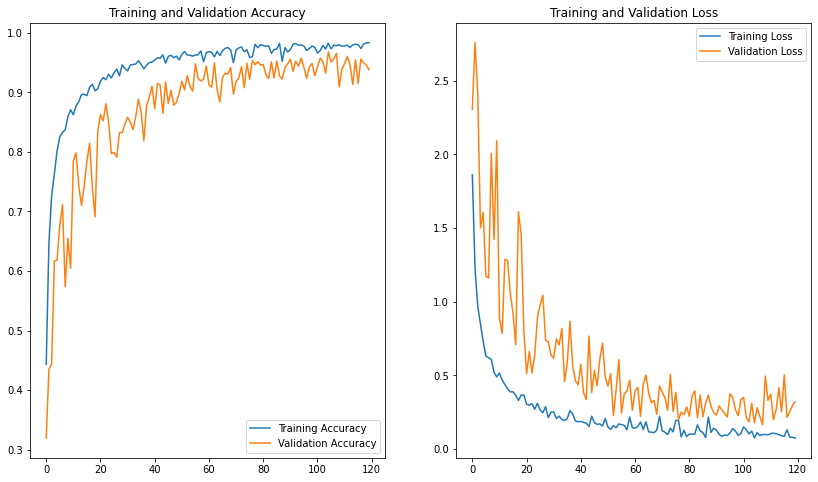

Maximum validation accuracy:  0.9684258103370667
Minimum loss: 0.1783662885427475


In [16]:
# Get the accuracy results for each epoch
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
# Get the loss results for each epoch
loss = history.history["loss"]
val_loss = history.history["val_loss"]
# Get the epochs count
epochs_range = range(len(history.history["loss"]))

# Create the plot area
plt.figure(figsize=(14, 8))

# Setup the first colum : Accuracy plot
plt.subplot(1, 2, 1)
# Plot the training and validation accuracy for these epochs
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
# Setup the legend
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

# Setup the second colum : Loss plot
plt.subplot(1, 2, 2)
# Plot the training and validation loss for these epochs
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
# Setup the legend
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

# Show the overall plot
plt.show()

position = np.argmax(history.history["val_accuracy"])
print(f"Maximum validation accuracy:  {history.history['val_accuracy'][position]}\nMinimum loss: {history.history['val_loss'][position]}")

# Display the model 📟

## Summary

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1

## Architecture

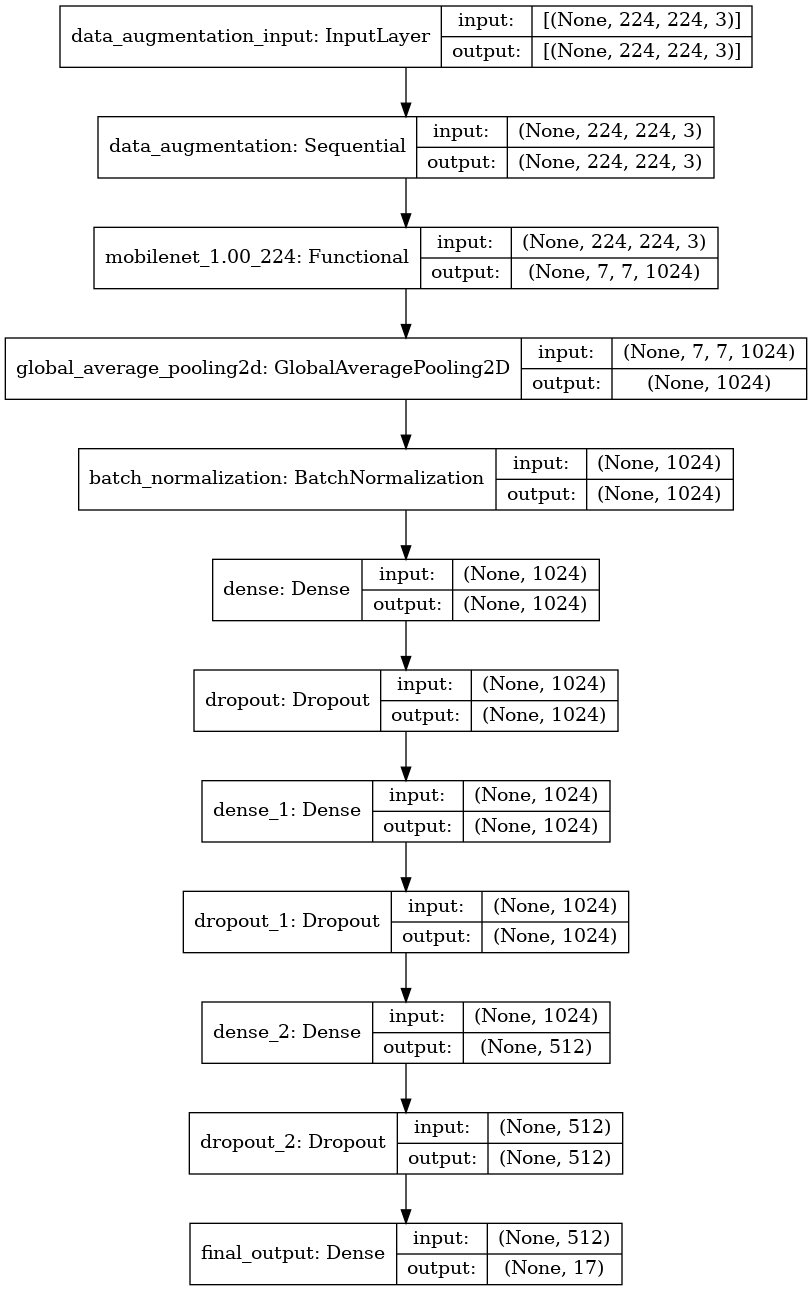

In [18]:
tf.keras.utils.plot_model(model,show_shapes=True)

# Evaluate the model  ⏲

Run inferences on the validation set

In [19]:
model.evaluate(x=val_dataset, return_dict=True)

70/70 [==============================] - 16s 205ms/step - loss: 0.1784 - accuracy: 0.9684


{'loss': 0.1783662736415863, 'accuracy': 0.9684258103370667}

# Save the model

In [20]:
model.save("One_Piece_Image_Classifier_Model_v16")

2022-04-27 17:37:21.331204: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
